In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Download close prices for 3 large-cap stocks
tickers = ["AAPL", "MSFT", "GOOGL"]
prices = yf.download(tickers, start="2018-01-01", end="2023-12-31")["Close"]
returns = prices.pct_change().dropna()

[*********************100%***********************]  3 of 3 completed


In [4]:
# Strategy functions 
def global_min_variance_portfolio(cov):
    inv = np.linalg.inv(cov)
    ones = np.ones(len(cov))
    return inv @ ones / (ones.T @ inv @ ones)

def maximum_return_portfolio(mean):
    weights = np.zeros(len(mean))
    weights[np.argmax(mean)] = 1
    return weights

def maximum_sharpe_ratio_portfolio(mean, cov, rf=0.0):
    excess = mean - rf
    weights = np.linalg.inv(cov) @ excess
    return weights/weights.sum()

In [5]:
# Rolling backtest
def rolling_backtest(returns, window=252):
    results = {k: [] for k in ["GMVP", "MRP", "MSRP"]}
    last_weights = {}
    for i in range(window, len(returns)):
        sample = returns.iloc[i-window:i]
        mu, cov = sample.mean(), sample.cov()
        gmvp = global_min_variance_portfolio(cov)
        mrp = maximum_return_portfolio(mu)
        msrp = maximum_sharpe_ratio_portfolio(mu, cov)
        for name, w in zip(results.keys(), [gmvp, mrp, msrp]):
            results[name].append(np.dot(returns.iloc[i], w))
            if i == len(returns) - 1:
                last_weights[name] = w  # Save last period weights
    return pd.DataFrame(results, index=returns.index[window:]), last_weights

In [6]:
# Run simulation 
bt_df, final_weights = rolling_backtest(returns)

In [7]:
# Metrics calculation
def compute_metrics(series):
    cagr = (1 + series.mean())**252 - 1
    vol = series.std() * np.sqrt(252)
    sharpe = cagr / vol
    cum = series.cumsum()
    max_dd = (cum - cum.cummax()).min()
    return pd.Series([cagr, vol, sharpe, max_dd], index=["CAGR", "Volatility", "Sharpe", "Max Drawdown"])

metrics = bt_df.apply(compute_metrics)
print("Performance Summary:\n")
print(metrics)

Performance Summary:

                  GMVP       MRP      MSRP
CAGR          0.389151  0.317640  1.175146
Volatility    0.284755  0.319465  3.340359
Sharpe        1.366619  0.994288  0.351802
Max Drawdown -0.369430 -0.395859 -4.610469


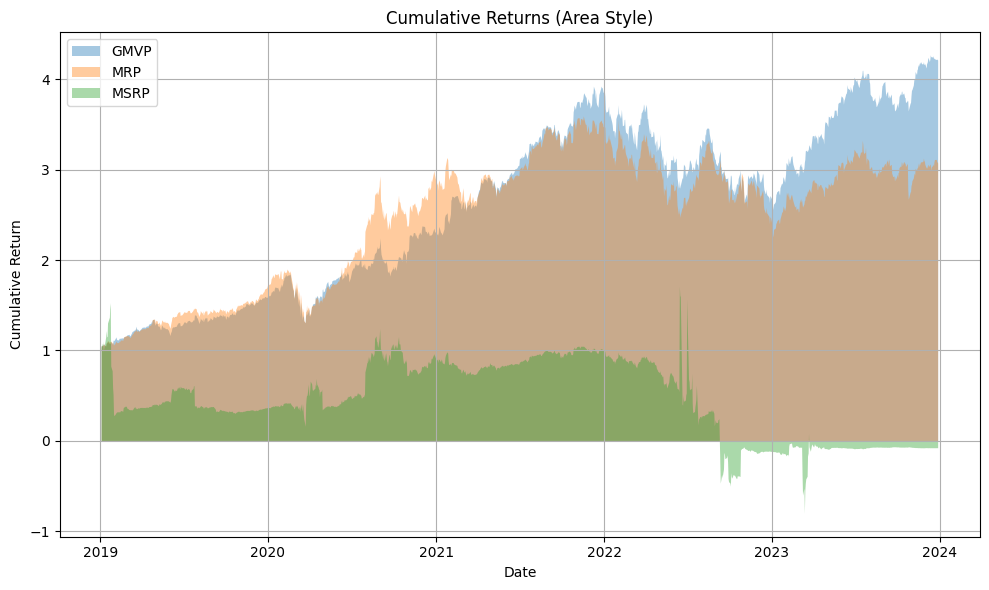

In [8]:
# 1. Fill-style Cumulative Return Plot
cum_ret = (1 + bt_df).cumprod()
plt.figure(figsize=(10, 6))
for name in cum_ret.columns:
    plt.fill_between(cum_ret.index, cum_ret[name], label=name, alpha=0.4)
plt.title("Cumulative Returns (Area Style)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/jb/p07zvg0j0hn8nh3ss_f5pk340000gp/T/ipykernel_8575/3605268789.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_returns = bt_df.resample("Y").apply(lambda x: (1 + x).prod() - 1)


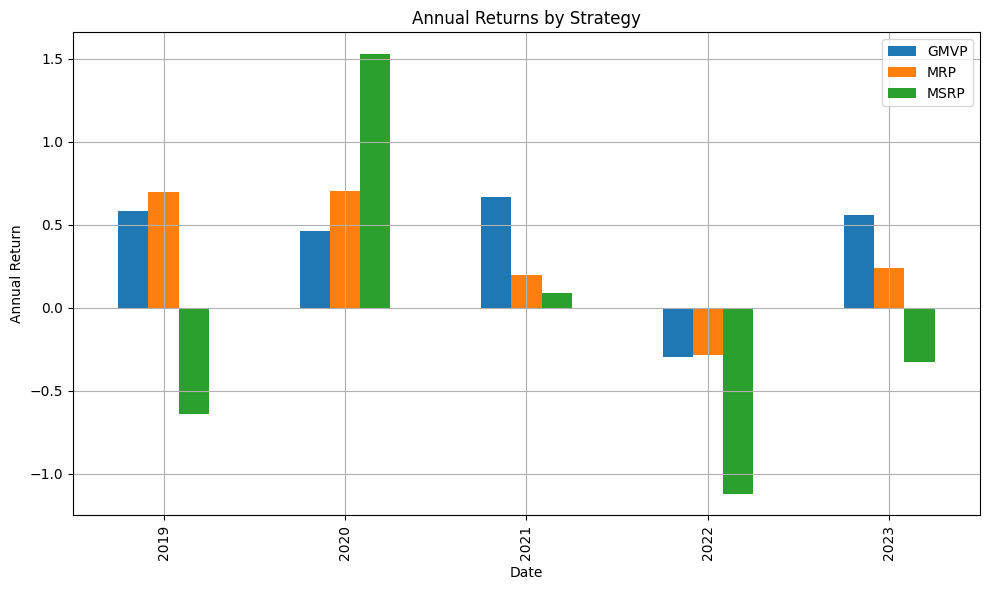

In [9]:
# 2. Yearly Return Bar Plot 
annual_returns = bt_df.resample("Y").apply(lambda x: (1 + x).prod() - 1)
annual_returns.index = annual_returns.index.year
annual_returns.plot(kind="bar", figsize=(10, 6))
plt.title("Annual Returns by Strategy")
plt.ylabel("Annual Return")
plt.grid(True)
plt.tight_layout()
plt.show()

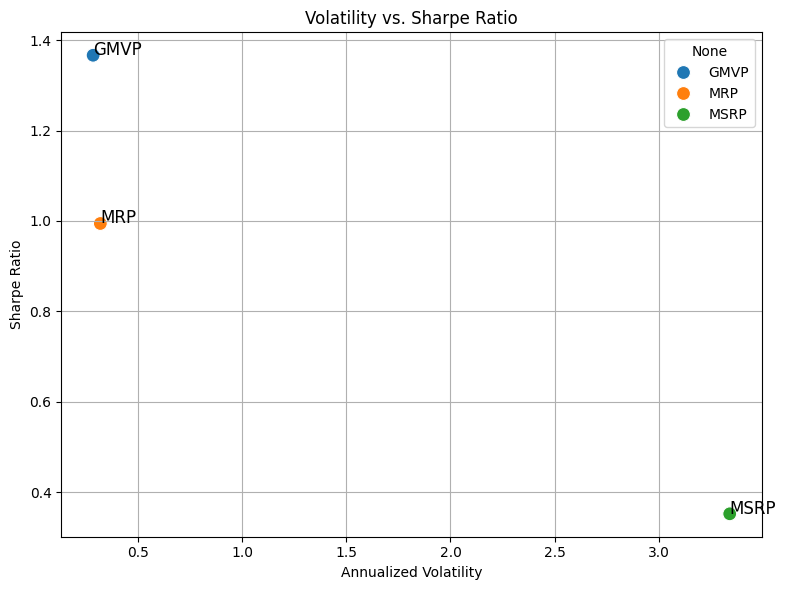

In [10]:
# 3. Volatility vs Sharpe Scatter 
plt.figure(figsize=(8, 6))
sns.scatterplot(x=metrics.loc["Volatility"], y=metrics.loc["Sharpe"], hue=metrics.columns, s=100)
for i in metrics.columns:
    plt.text(metrics.loc["Volatility", i], metrics.loc["Sharpe", i], i, fontsize=12)
plt.title("Volatility vs. Sharpe Ratio")
plt.xlabel("Annualized Volatility")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

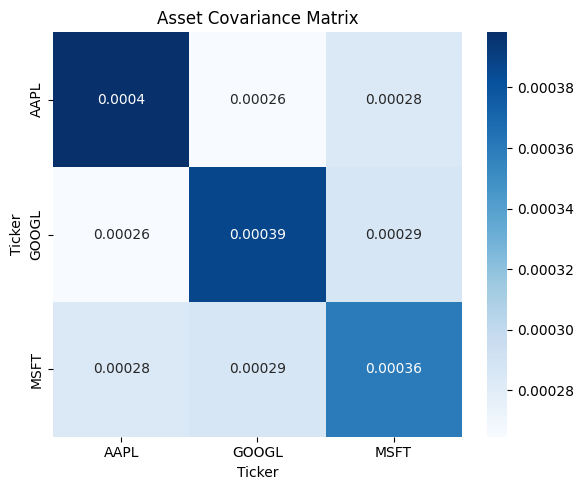

In [11]:
# 4. Covariance Matrix Heatmap 
plt.figure(figsize=(6, 5))
sns.heatmap(returns.cov(), annot=True, cmap="Blues")
plt.title("Asset Covariance Matrix")
plt.tight_layout()
plt.show()

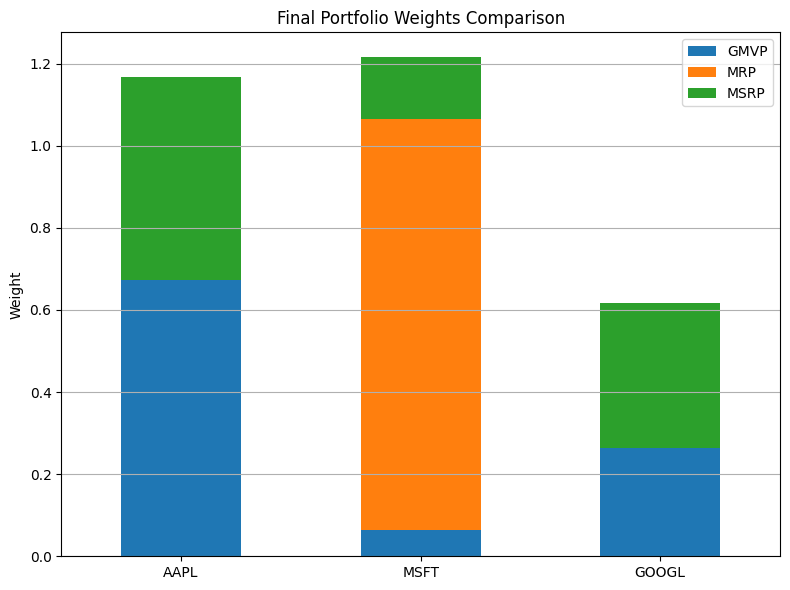

In [12]:
# 5. Final Portfolio Weights Bar Chart 
weight_df = pd.DataFrame(final_weights, index=tickers)
weight_df.plot(kind="bar", stacked=True, figsize=(8, 6))
plt.title("Final Portfolio Weights Comparison")
plt.ylabel("Weight")
plt.grid(True, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()